<h1><center>An Agent-based Economy Model</center></h1>

## Running the Agent-based Model

<span style="color:darkorange">Set the SDK path and maven repository path here.</span>

In [1]:
from joblib import Parallel, delayed
from tqdm import trange
from IPython.display import display, HTML

import json

display(HTML("<style>.container { width:90% !important; }</style>"))
with open('notebook_settings.json', 'r') as f:
    notebook_settings = json.load(f)

In [2]:
# Example of sector data
sector_data = {
    'E36': {
         'I': 319, 'N': 1860, 'alpha':0.0988, 'beta': 2.5567, 'kappa': 0.0399, 'delta': 0.0095, 'w': 0.0134,
        'tauY': 0.0071, 'tauK': 0.0266, 'bCF_g': 0, 'bCFH_g': 0, 'bHH_g': .001, 'cG_g': 0, 'cE_g': 0, 'cI_g': 0
    }
}

In [3]:
import os

from utils import *

seed = 123
level = 'WARN'
params = {
    'vm': {'seed': seed, 'runs': 1, 'ticks': 12, 
           'level': level, 'levelHH': level, 'levelFirm': level, 'levelEconomy': level},
    'config': {'simudyne.core.export-path': 'Output_{0}'.format(seed)},
    'input': {'G': 2, 'I': 100, 'H': 1000, 'alpha': .0052, 'w': .2, 'kappa': .03, 'delta': 0.01,
              'wh0': 40., 'C_h_d0': 10.0, 'beta': 1.5, 'bCF_g': 0.0, 'bCFH_g': 0.0, 'bHH_g': 0.0092, 
              'cG_g': 0, 'cE_g': 0, 'cI_g': 0, 'a_s_g': .1, 'pi': .01},
    'notebook_settings' : notebook_settings
}

# <span style="color:blue">Calibration using Xgboost Surrogate Modelling</span>

##### Using the package 'skopt'

## Historical Data

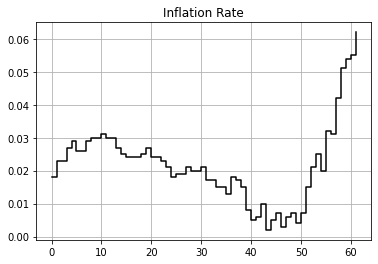

In [4]:
inflation_rate = pd.read_csv('/Users/perukrishnenvytelingum/GitHub/ClimateRiskABM-V1/data/cpi.csv', 
                             header=None).loc[0].iloc[:-1]
inflation_rate.plot(color='k', grid=True, title='Inflation Rate', drawstyle='steps-post')
cal = inflation_rate.diff().agg([np.mean, np.std])
historical_data = {'inflation_rate': cal}

## Run Surrogate Modelling

In [5]:
%%time

import warnings

from skopt import gbrt_minimize
from skopt.plots import plot_gaussian_process

mc = 1
bounds = {'alpha': (0.001, 0.009), 'w': (0.1, .5), 'kappa': (0.001, .1), 'delta': (0.001, .1), 
          'beta': (0., 3.)}
variables = ['alpha', 'w', 'kappa', 'delta', 'beta']
variables = ['alpha', 'w']

np.random.seed(1234)

_bounds = [bounds[k] for k in variables]
obj_fn = lambda x: f(x, variables, params, f_error=get_error_ir, mc=mc, historical_data=historical_data)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = gbrt_minimize(obj_fn,             # the function to minimize
                        _bounds,            # the bounds on each dimension of x
                        acq_func="EI",      # the acquisition function
                        n_calls=100,         # the number of evaluations of f
                        n_jobs=6,
                        n_random_starts=2,  # the number of random initialization points
                        random_state=1234)  # the random seed

CPU times: user 4min 21s, sys: 10.6 s, total: 4min 31s
Wall time: 18min 6s


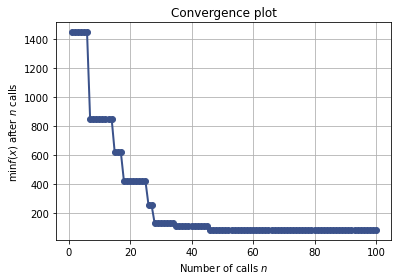

In [6]:
from skopt.plots import plot_convergence

ax = plot_convergence(res)
ax.set_yscale('linear')

In [7]:
from skopt.plots import plot_convergence

if len(variables) == 1:
    for i in np.arange(1, 5):
        fg, ax = plt.subplots(1, 1, figsize=(10, 4))
        plot_gaussian_process(res, ax=ax, n_calls=i, objective=None, noise_level=1e-6, show_legend=True, 
                                   show_title=True, show_next_point=True, show_acq_func=True)
        ax.set_yscale('linear')
        plt.show()

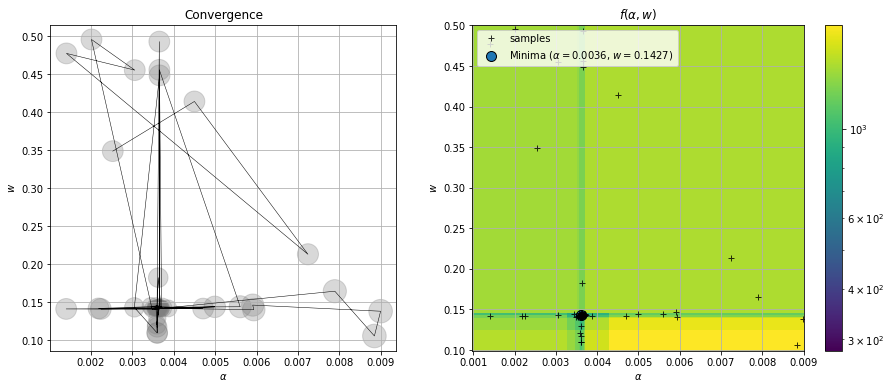

In [8]:
if variables == ['alpha', 'w']:
    import matplotlib.colors as colors
    
    fg, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [5, 6]})

    df = pd.DataFrame(res['x_iters'], columns=variables)

    df.set_index('alpha')['w'].plot(ax=ax, color='k', lw=.5)
    ax.scatter(df['alpha'], df['w'], s=res['func_vals'] * .3, marker='o', alpha=.3, facecolor='gray')
    ax.grid(True)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$w$')
    ax.set_title('Convergence')

    n_grid_pts = 200
    x1_values = np.linspace(bounds[variables[0]][0], bounds[variables[0]][1], n_grid_pts)
    x2_values = np.linspace(bounds[variables[1]][0], bounds[variables[1]][1], n_grid_pts)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape(res['models'][-1].predict(vals), (n_grid_pts, n_grid_pts))
    cm = ax2.pcolormesh(x_ax, y_ax, fx, norm=colors.LogNorm(vmin=fx.min(), vmax=fx.max()), cmap='viridis')
    df.set_index('alpha')['w'].plot(ax=ax2, style='+k', lw=.5, alpha=.8, label='samples')
    ax2.scatter(res['x'][0], res['x'][1], facecolor=None, edgecolor='k', s=100, 
                label=r'Minima ({2}{0:.4f}, {3}{1:.4f})'.format(res['x'][0], res['x'][1], r'$\alpha=$', r'$w=$'))
    fg.colorbar(cm)
    ax2.grid(True)
    ax2.legend(loc='upper left')
    ax2.set_xlabel(r'$\alpha$')
    ax2.set_ylabel(r'$w$')
    ax2.set_title(r'$f(\alpha, w)$')

## Calibrated Model

In [9]:
opt_pt = {variables[i]: res['x'][i] for i in np.arange(len(variables))}
print('Optimal solution: ', opt_pt)

Optimal solution:  {'alpha': 0.0036186121812030077, 'w': 0.14265651352540942}


In [10]:
n_mc = 3
seeds = np.random.randint(0, 1000000, n_mc)

_res = Parallel(n_jobs=6, verbose=8)(delayed(get_sim)(opt_pt, params, i=i, seed=seeds[i]) for i in np.arange(n_mc))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   26.8s finished


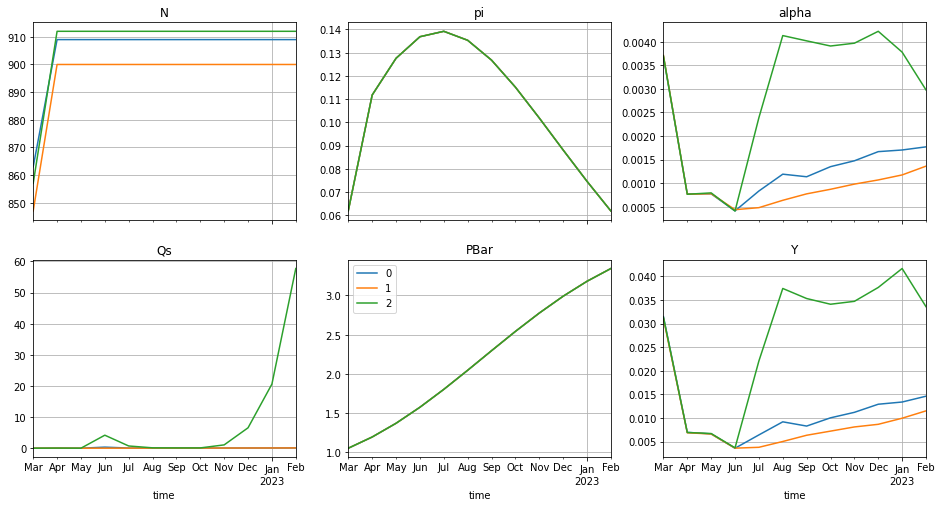

In [11]:
plot_res(_res)

In [15]:
from utils import _get_sim

__res = _get_sim(opt_pt, params, i=0, seed=1234)

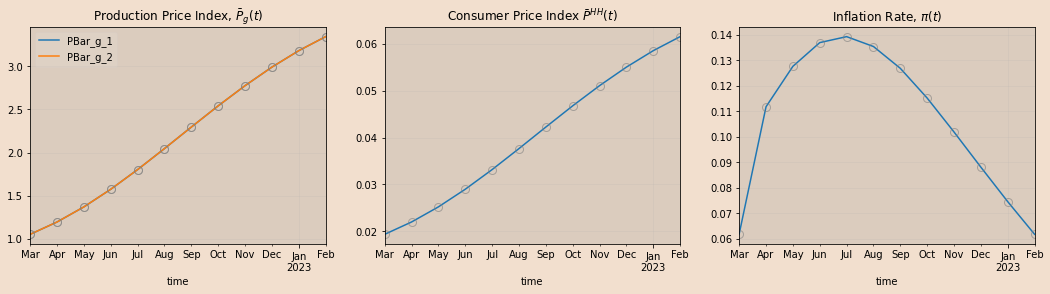

In [28]:
run_id = 'run000000000'
G = __res[run_id]['Economy'].set_index('time')
PBar_g = G[[i for i in G.columns if 'PBar_g' in i]]

plot_dict({'Production Price Index, {0}'.format(r'$\bar{P}_{g}(t)$'): PBar_g, 
           'Consumer Price Index {0}'.format(r'$\bar{P}^{HH}(t)$'): get_variable(__res, run_id, 'Economy', 'PBarHH'), 
           'Inflation Rate, {0}'.format(r'$\pi(t)$'): get_variable(__res, run_id, 'Economy', 'pi')}, 
          figsize=(18, 4), legend=True)

<AxesSubplot:>

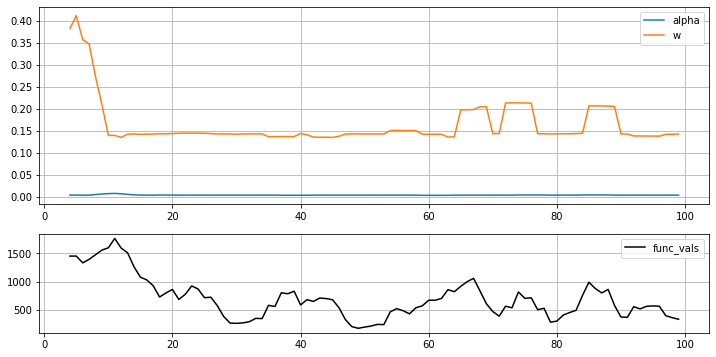

In [12]:
fg, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [2, 1]})
pd.DataFrame(res['x_iters'], columns=variables).rolling(5).mean().plot(ax=axs[0], grid=True)
pd.DataFrame({'func_vals': res['func_vals']}).rolling(5).mean().plot(ax=axs[1], grid=True, color='k')